## Question 1 - Location Capacity  and Rate

In [1]:
data <- readRDS("data/cohort_dat_assess.RDS")
dim(data)

[1] 1740   14

In [2]:
head(data, 5)

,person_id,case_id,arrival_location_id,case_size,ArrivalDate,arrival_age,Nationality_norm,sex,free_case,hard_singles_male,hard_singles_female,hard_spf,case_placement_order,arrival_location_order
,<chr>,<chr>,<chr>,<dbl>,<date>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,c9f1f43713aec0031d0aea40e352dcb3e0e3996b02b85cb586c06892bdf471f9,1d31071c3708db8e408bc7db26f95b2c,88311c24,1,2023-02-15,20,burma,Male,1,1,0,0,1,1
2,ce9ba115156522cc5bb0e49376d0e14c6466824c55bf74f5ad1fee0b3f4cfde4,3c01df8e5923ad49c08fe61e41972e32,2cc2591c,2,2023-02-15,28,centralafricanrepublic,Female,1,1,0,1,2,2
3,b731703d813525598f2c5619acaf713f267fec1074cc8dedf5c424873f0dc10a,471c3ac6818d8852b0bbfb82783a90d1,56af9059,6,2023-02-15,36,afghanistan,Male,0,0,0,0,3,3
4,7cc766e9de02dbfe21de38e2586b424b4fce3dbda7e35969791b0308973da466,471c3ac6818d8852b0bbfb82783a90d1,56af9059,6,2023-02-15,36,afghanistan,Female,0,0,0,0,3,3
5,ec32d62b6729a36ce96a4f80435a4fb2b916aaaa83199da51190793ef22f86bf,4ebd2d38396e5de256877b762172507e,b5b999a4,1,2023-02-15,31,burma,Female,0,0,1,0,4,4


To find each location's capacity quota - we need to find the sum of case_size per unique case_id for each location

In [3]:
library(dplyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [4]:
# total capacity of each arrival location

#group by arrival location and case id, and since they are repeated within a case, we take either avg/min/max of case size
# then group by arrival location and sum the case size to get the total capacity of each arrival location
#(after group by we need to do an aggregate function which in this case is min/max/avg) 

location_capacity <- data %>% 
    group_by(arrival_location_id, case_id) %>% 
    summarise(sum_case_size= mean(case_size)) %>%
    group_by(arrival_location_id) %>% 
    summarise(capacity_quota = sum(sum_case_size))
    
head(location_capacity, 10)

`summarise()` has grouped output by 'arrival_location_id'. You can override
using the `.groups` argument.


arrival_location_id,capacity_quota
<chr>,<dbl>
0a63bef4,57
0a91d577,34
0b8769f2,32
11b8b71f,65
18d79a06,47
19334d00,93
19c12683,172
2449a303,103
2c30329f,52


In [5]:
#find the total capacity 
total_capacity <- sum(location_capacity$capacity_quota)
total_capacity

[1] 3392

In [6]:
#calculating capcity rate for each arrival location - cacpacity rate = capacity_quota/total_capacity
location_capacity <- location_capacity %>%
                     mutate(capacity_rate = total_capacity/capacity_quota)
                     
head(location_capacity, 5)

arrival_location_id,capacity_quota,capacity_rate
<chr>,<dbl>,<dbl>
0a63bef4,57,59.50877
0a91d577,34,99.76471
0b8769f2,32,106.00000
11b8b71f,65,52.18462
18d79a06,47,72.17021


### Part A.  - average capacity across all locations


In [7]:
# average capacity across all locations 
avg_capacity <- mean(location_capacity$capacity_quota)
avg_capacity

[1] 67.84

 <b>The Average capcity across all locations is 67.84 <b>

### Part B. - average rate across all locations

In [8]:
# average capcity rate across all locations
avg_capacity_rate <- mean(location_capacity$capacity_rate)
avg_capacity_rate

[1] 90.56843

<b>The Average capcity rate across all locations is 90.56<b>

## Question 2 - Eligibility Constraints

APPROACH

1. Join nationalities and casetypes dataframes to get the constraints of each arrival_location (i.e list of countries they can accept, and case characteristics)
2. For each case, get a list of nationalities and and list of case constraints (SPF, SingleMale, SingleFemale, etc)
3. Do a cross join of the two, and check the constraints. 


In [9]:
nationality <- read.csv("data/AFF_Nationality.csv")
head(nationality, 5)

casetype <- read.csv("data/AFF_CaseType.csv")
head(casetype, 5)

,arrival_location_id,Nationality_norm
,<chr>,<chr>
1,91350746,afghanistan
2,91350746,burma
3,91350746,demrepcongo
4,91350746,colombia
5,91350746,cuba


,arrival_location_id,CaseType,Accepted
,<chr>,<chr>,<chr>
1,91350746,SingleIndividualFemale,Yes
2,91350746,SingleIndividualMale,Yes
3,91350746,SingleParentFamilies,Yes
4,3e767dee,SingleIndividualFemale,Yes
5,3e767dee,SingleIndividualMale,Yes


In [10]:
#find number of unique arrival_location_id in casetype data with accepted cases

casetype %>% filter (Accepted == 'Yes') %>% summarise(n_distinct(arrival_location_id))
# length(unique(casetype$arrival_location_id))


#find number of unique arrival_location_id in casetype data
casetype %>% summarise(n_distinct(arrival_location_id))


n_distinct(arrival_location_id)
<int>
45


n_distinct(arrival_location_id)
<int>
50


#### Locations that cannot accomodate any constraints

In [11]:
## finding locations that can't accomodate any constraints - group by arrival_location_id and find the sum if 'No' in Accepted column
xdf = casetype %>% 
      filter (Accepted == 'No') %>%
      group_by(arrival_location_id) %>%
      summarise(sum_not_accepted = sum(Accepted == 'No')) %>% 
      filter(sum_not_accepted == 3)

xdf



locations_with_no_constraint_accom <- data.frame(
  arrival_location_id = xdf$arrival_location_id,
  unique_casetype_l = character(length = nrow(xdf))
)

#change unique_casetype_l to a list
locations_with_no_constraint_accom$unique_casetype_l <-
 as.list(locations_with_no_constraint_accom$unique_casetype_l)


locations_with_no_constraint_accom  

arrival_location_id,sum_not_accepted
<chr>,<int>
2449a303,3
547082d0,3
a61b01d3,3
cd0b4268,3
cdf929eb,3


arrival_location_id,unique_casetype_l
<chr>,<list>
2449a303,
547082d0,
a61b01d3,
cd0b4268,
cdf929eb,


In [12]:
## focusing only on free cases
data_free_cases <- data %>% filter(free_case == 1)

#find distinct case_id in data_free_cases
data_free_cases %>% summarise(n_distinct(case_id))

n_distinct(case_id)
<int>
211


In [13]:
##checking the free cases that have no constraints

data_free_cases %>% 
    filter(hard_singles_male == 0 & hard_singles_female ==0 & hard_spf ==0) %>%
    summarise(n_distinct(case_id))

n_distinct(case_id)
<int>
109


In [14]:
# for each case_id, find the number of unique_nationality_norm
tdf = data_free_cases %>% 
        group_by(case_id) %>% 
        summarise(unique_nationality_count = n_distinct(Nationality_norm)) %>%
        filter(unique_nationality_count > 1)
tdf


#find unique caes in data_free_cases
nrow(data_free_cases %>% group_by(case_id) %>% summarise(n_distinct(case_id)))


case_id,unique_nationality_count
<chr>,<int>
127c782ae14732909574ab9bc3be5f74,2
47e2cf5d31fbf875f2e85521a1daf3a0,2
4947c3e4172599b258186dea16422062,2
87253f40d2bb0828aebd58d5dacdc64e,2
a04a1232dbe0004c3d262b8f50e68bc9,2


[1] 211

From the above, we see that there are some cases that contain multiple nationalities - so the nationality constraint cannot be ignored for these cases.

In [15]:
#changing the data type of factor columns to character
fctr_cols <- sapply(data_free_cases, is.factor)
# fctr_cols
data_free_cases[fctr_cols] <- lapply(data_free_cases[fctr_cols], as.character)

### Dataframes to set up constraints

In [16]:
#dataframes to set up nationalality constraints
# for each nationality - which locations can they accomodate 

print('**** nationalities by location ****')
nationalities_by_location = nationality %>% 
                            group_by(arrival_location_id) %>%
                            summarise(unique_nationalities_l = list(unique(Nationality_norm)))

head(nationalities_by_location,2)
nrow(nationalities_by_location)

print('**** nationalities by case ****')
# for each case, which nationalities need to be accomodated
nationalities_by_case <- data_free_cases %>%
                        group_by(arrival_location_id, case_id) %>%
                        summarise(unique_nationalities_c = list(unique(Nationality_norm)))


head(nationalities_by_case,2)
nrow(nationalities_by_case)


print('***** casetype by location ****')



# data frames to set up case   constraints
# for each location, case types that can be accomodated


casetype_by_location = casetype %>% 
                        filter(Accepted == "Yes") %>% 
                        group_by(arrival_location_id) %>% 
                        summarise(unique_casetype_l = list(unique(CaseType)))

#TARUNI CHECK
casetype_by_location = rbind(casetype_by_location, locations_with_no_constraint_accom)


head(casetype_by_location,2)
nrow(casetype_by_location)

# print('****print hsf, hsm spf ***')

# for each case, case types that need to be accomodated
hard_singles_male_by_case <- data_free_cases %>% 
                            group_by(arrival_location_id, case_id) %>% 
                            summarise(unique_hard_singles_male_c = max(hard_singles_male)) %>%
                            mutate(constraints= ifelse(unique_hard_singles_male_c == 1, 'SingleIndividualMale', 'no'))

hard_singles_female_by_case <- data_free_cases %>%
                                group_by(arrival_location_id, case_id) %>% 
                                summarise(unique_hard_singles_female_c = max(hard_singles_female)) %>%
                                mutate(constraints = ifelse(unique_hard_singles_female_c == 1, 'SingleIndividualFemale', 'no'))


hard_spf_by_case <- data_free_cases %>%
                     group_by(arrival_location_id, case_id) %>% 
                     summarise(unique_hard_spf_c = max(hard_spf))%>%
                     mutate(constraints = ifelse(unique_hard_spf_c  == 1, 'SingleParentFamilies', 'no'))

# head(hard_singles_female_by_case)
# head(hard_singles_male_by_case)
# head(hard_spf_by_case)


print('**** constraints by case ***')

# now we need to cross join data_free_cases and nationality dataframes to get all possible combinations of free case and locations
#cross join data_free_cases and nationality dataframes 



# For each free case - location combination, we check if 1. nationality constraints and 2. case constraints are satisfied


constraints_by_case =rbind(hard_singles_female_by_case,hard_singles_male_by_case,hard_spf_by_case) %>% 
                    group_by(arrival_location_id, case_id) %>% 
                    summarise(constraints = list(unique(constraints))) 
                    

# remove 'no' from each element of the constraints list
constraints_by_case$constraints <- lapply(constraints_by_case$constraints, function(x) x[x != 'no'])
# head(constraints_by_case,2)

[1] "**** nationalities by location ****"


arrival_location_id,unique_nationalities_l
<chr>,<list>
0a63bef4,"afghanistan, burma , congo , colombia , guatemala , honduras , iran , iraq , moldova , peru , syria , ukraine , venezuela"
0a91d577,"guatemala , centralafricanrepublic, pakistan , mali , russia , colombia , indonesia , palestine , iraq , cambodia , sudan , venezuela , demrepcongo , burma , moldova , ivorycoast , ukraine , somalia , eritrea , cameroon , chad , vietnam , iran , yemen , elsalvador , honduras , haiti , nepal , china , syria , burundi , southsudan"


[1] 50

[1] "**** nationalities by case ****"


`summarise()` has grouped output by 'arrival_location_id'. You can override
using the `.groups` argument.


arrival_location_id,case_id,unique_nationalities_c
<chr>,<chr>,<list>
0a91d577,3016d6f92dbf2c4b4734cd34e34e5b76,colombia
0b8769f2,5af9e51b30600d5957da5eb48509a368,venezuela


[1] 211

[1] "***** casetype by location ****"


arrival_location_id,unique_casetype_l
<chr>,<list>
0a63bef4,"SingleIndividualFemale, SingleIndividualMale , SingleParentFamilies"
0a91d577,"SingleIndividualFemale, SingleIndividualMale , SingleParentFamilies"


[1] 50

`summarise()` has grouped output by 'arrival_location_id'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'arrival_location_id'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'arrival_location_id'. You can override
using the `.groups` argument.


[1] "**** constraints by case ***"


`summarise()` has grouped output by 'arrival_location_id'. You can override
using the `.groups` argument.


In [17]:
head(constraints_by_case,5)
nrow(constraints_by_case)

arrival_location_id,case_id,constraints
<chr>,<chr>,<list>
0a91d577,3016d6f92dbf2c4b4734cd34e34e5b76,
0b8769f2,5af9e51b30600d5957da5eb48509a368,SingleParentFamilies
0b8769f2,c7bd61f95f6844da38cf7631f4c4f856,SingleParentFamilies
0b8769f2,ccae717b09082b7528132b8c18c91b24,
0b8769f2,ebe9adc54f7edcfa281ea7f247f80465,SingleParentFamilies


[1] 211

### Cross joining locations with cases to get all possible combinations

In [18]:

arrival_locations <- merge(nationalities_by_location, casetype_by_location, by = 'arrival_location_id')
print('**** arrival locations ****')
head(arrival_locations,2)

# arrival_locations_merge <- merge(arrival_locations, data_free_cases, by = NULL)

case_info <- merge(nationalities_by_case, constraints_by_case, by = c('arrival_location_id', 'case_id')) %>% 
                select(-arrival_location_id)
print('**** case info ****')
head(case_info,2)

#cross join case_info with arrival_locations to get all possible combinations of case_id and arrival_location_id    
case_info_merge <- merge(case_info, arrival_locations, by = NULL)
# head(case_info_merge,2)

print('**** all possible case location combinations ****')
head(case_info_merge,2)

#checking if the merge is correct
dim(arrival_locations)
dim(case_info)
dim(case_info_merge)

[1] "**** arrival locations ****"


,arrival_location_id,unique_nationalities_l,unique_casetype_l
,<chr>,<list>,<list>
1,0a63bef4,"afghanistan, burma , congo , colombia , guatemala , honduras , iran , iraq , moldova , peru , syria , ukraine , venezuela","SingleIndividualFemale, SingleIndividualMale , SingleParentFamilies"
2,0a91d577,"guatemala , centralafricanrepublic, pakistan , mali , russia , colombia , indonesia , palestine , iraq , cambodia , sudan , venezuela , demrepcongo , burma , moldova , ivorycoast , ukraine , somalia , eritrea , cameroon , chad , vietnam , iran , yemen , elsalvador , honduras , haiti , nepal , china , syria , burundi , southsudan","SingleIndividualFemale, SingleIndividualMale , SingleParentFamilies"


[1] "**** case info ****"


,case_id,unique_nationalities_c,constraints
,<chr>,<list>,<list>
1,3016d6f92dbf2c4b4734cd34e34e5b76,colombia,
2,5af9e51b30600d5957da5eb48509a368,venezuela,SingleParentFamilies


[1] "**** all possible case location combinations ****"


,case_id,unique_nationalities_c,constraints,arrival_location_id,unique_nationalities_l,unique_casetype_l
,<chr>,<list>,<list>,<chr>,<list>,<list>
1,3016d6f92dbf2c4b4734cd34e34e5b76,colombia,,0a63bef4,"afghanistan, burma , congo , colombia , guatemala , honduras , iran , iraq , moldova , peru , syria , ukraine , venezuela","SingleIndividualFemale, SingleIndividualMale , SingleParentFamilies"
2,5af9e51b30600d5957da5eb48509a368,venezuela,SingleParentFamilies,0a63bef4,"afghanistan, burma , congo , colombia , guatemala , honduras , iran , iraq , moldova , peru , syria , ukraine , venezuela","SingleIndividualFemale, SingleIndividualMale , SingleParentFamilies"


[1] 50  3

[1] 211   3

[1] 10550     6

In [19]:
# head(case_info_merge,10)

#check eligibility

case_info_merge$location_accom = mapply(function(c, l) all(c %in% l), case_info_merge$unique_nationalities_c, case_info_merge$unique_nationalities_l)
case_info_merge$case_accom = mapply(function(c, l) all(c %in% l), case_info_merge$constraints, case_info_merge$unique_casetype_l)

dim(case_info_merge)

head(case_info_merge, 2)

[1] 10550     8

,case_id,unique_nationalities_c,constraints,arrival_location_id,unique_nationalities_l,unique_casetype_l,location_accom,case_accom
,<chr>,<list>,<list>,<chr>,<list>,<list>,<lgl>,<lgl>
1,3016d6f92dbf2c4b4734cd34e34e5b76,colombia,,0a63bef4,"afghanistan, burma , congo , colombia , guatemala , honduras , iran , iraq , moldova , peru , syria , ukraine , venezuela","SingleIndividualFemale, SingleIndividualMale , SingleParentFamilies",TRUE,TRUE
2,5af9e51b30600d5957da5eb48509a368,venezuela,SingleParentFamilies,0a63bef4,"afghanistan, burma , congo , colombia , guatemala , honduras , iran , iraq , moldova , peru , syria , ukraine , venezuela","SingleIndividualFemale, SingleIndividualMale , SingleParentFamilies",TRUE,TRUE


In [20]:

#filter by the rows where both location_accom and case_accom are true
case_info_merge <- case_info_merge %>% filter(location_accom == TRUE & case_accom == TRUE)
# head(case_info_merge,10)

eligible_cases = case_info_merge


In [21]:
#check if join works for a case with no constraints and a location that can accomodate no constraints

#case with no constraints = 101f0746ae4dfe8c6d7607020fd1b50e
# location with no constraints accom  =2449a303


# case_info_merge %>% filter(case_id == '101f0746ae4dfe8c6d7607020fd1b50e' & arrival_location_id == '2449a303')

### Eligible Cases

In [22]:
dim(eligible_cases)
head(eligible_cases, 5)

# eligible_cases

[1] 5241    8

,case_id,unique_nationalities_c,constraints,arrival_location_id,unique_nationalities_l,unique_casetype_l,location_accom,case_accom
,<chr>,<list>,<list>,<chr>,<list>,<list>,<lgl>,<lgl>
1,3016d6f92dbf2c4b4734cd34e34e5b76,colombia,,0a63bef4,"afghanistan, burma , congo , colombia , guatemala , honduras , iran , iraq , moldova , peru , syria , ukraine , venezuela","SingleIndividualFemale, SingleIndividualMale , SingleParentFamilies",TRUE,TRUE
2,5af9e51b30600d5957da5eb48509a368,venezuela,SingleParentFamilies,0a63bef4,"afghanistan, burma , congo , colombia , guatemala , honduras , iran , iraq , moldova , peru , syria , ukraine , venezuela","SingleIndividualFemale, SingleIndividualMale , SingleParentFamilies",TRUE,TRUE
3,ccae717b09082b7528132b8c18c91b24,syria,,0a63bef4,"afghanistan, burma , congo , colombia , guatemala , honduras , iran , iraq , moldova , peru , syria , ukraine , venezuela","SingleIndividualFemale, SingleIndividualMale , SingleParentFamilies",TRUE,TRUE
4,ebe9adc54f7edcfa281ea7f247f80465,venezuela,SingleParentFamilies,0a63bef4,"afghanistan, burma , congo , colombia , guatemala , honduras , iran , iraq , moldova , peru , syria , ukraine , venezuela","SingleIndividualFemale, SingleIndividualMale , SingleParentFamilies",TRUE,TRUE
5,0376d9bd13537af8cd39a4b7143e7ee9,syria,,0a63bef4,"afghanistan, burma , congo , colombia , guatemala , honduras , iran , iraq , moldova , peru , syria , ukraine , venezuela","SingleIndividualFemale, SingleIndividualMale , SingleParentFamilies",TRUE,TRUE


## Question 2 - Part A

In [23]:
# in eligible_cases, group by case_id and count the number of arrival_location_id

eligible_cases_count <- eligible_cases %>%
                         group_by(case_id) %>% 
                         summarise(count_of_locations = n())
                         
head(eligible_cases_count, 5)

#avg of count_of_locations
avg_count_of_locations <- mean(eligible_cases_count$count_of_locations)
print(avg_count_of_locations)

case_id,count_of_locations
<chr>,<int>
00ebf80e98ad62ff7fbc2e7b423f592a,24
01c06c951c9a5f4c57e19975e70f9f6e,29
01ec723682e2a490d930a06e38ba6891,33
0376d9bd13537af8cd39a4b7143e7ee9,33
0421935425294ee30e13f865c168b8f2,21


[1] 24.83886


### Avegage locations eligible across all free cases is 24.83

## Question 2 Part B

In [24]:
min_count_of_locations <- min(eligible_cases_count$count_of_locations)
print(min_count_of_locations)

[1] 2


### Min num of locations eligible across all free cases is 2

## Question 2 Part C

In [25]:
max_count_of_locations <- max(eligible_cases_count$count_of_locations)
print(max_count_of_locations)

[1] 45


### Max num of locations eligible across all free cases is 45

### Eligible locations for each case

In [26]:
# for each case_id, find the list of unique arrival_location_id, and number of unique arrival_location_id


unique_locations_per_case <- eligible_cases %>% group_by(case_id) %>%
 summarise(
    unique_locations = list(unique(arrival_location_id)) , 
    count_of_unique_locations = n_distinct(arrival_location_id)
    ) %>% 
    arrange(desc(count_of_unique_locations))

 tail(unique_locations_per_case, 5)
 head(unique_locations_per_case, 2)

case_id,unique_locations,count_of_unique_locations
<chr>,<list>,<int>
3fc41c6d61713e249759adb790b52e53,"0a91d577, cc1dfeed",2
52e40eb234ae4e915249c8f1b151d72b,"0a91d577, 3e767dee",2
85b51a5743da5d3afa3f4fff5e49930c,"0a91d577, 3e767dee",2
87253f40d2bb0828aebd58d5dacdc64e,"0a91d577, eb58ce03",2
95c52b4f4e134fa302b8b73237e073d8,"0a91d577, 3e767dee",2


case_id,unique_locations,count_of_unique_locations
<chr>,<list>,<int>
0bd41fb94257003e5e5d7c3c8f8d12ed,"0a63bef4, 0b8769f2, 11b8b71f, 18d79a06, 19334d00, 19c12683, 2449a303, 2c30329f, 2cc2591c, 2d268e1a, 2e1d4b95, 371950f7, 3e767dee, 3f60c16b, 3f92aae8, 450d082e, 45ff63ad, 47d21aa7, 700e77b1, 7335b23e, 7a5a9f27, 815e313d, 8265f4b2, 88311c24, 91350746, a4c4135a, b5b999a4, b794e0ae, c572d3f4, cc1dfeed, cd0b4268, cdf929eb, d6222000, dc76c896, de5bb19c, dea9da1f, df4d0d19, e3d3341c, eabc1905, eb58ce03, ebaaa580, f083c7e8, f8083df7, f8fa5674, f9eceaf1",45
0fc6b939596e8edafcd96065f9c1e75e,"0a63bef4, 0b8769f2, 11b8b71f, 18d79a06, 19334d00, 19c12683, 2449a303, 2c30329f, 2cc2591c, 2d268e1a, 2e1d4b95, 371950f7, 3e767dee, 3f60c16b, 3f92aae8, 450d082e, 45ff63ad, 47d21aa7, 700e77b1, 7335b23e, 7a5a9f27, 815e313d, 8265f4b2, 88311c24, 91350746, a4c4135a, b5b999a4, b794e0ae, c572d3f4, cc1dfeed, cd0b4268, cdf929eb, d6222000, dc76c896, de5bb19c, dea9da1f, df4d0d19, e3d3341c, eabc1905, eb58ce03, ebaaa580, f083c7e8, f8083df7, f8fa5674, f9eceaf1",45


In [27]:
#how many cases have 45 unique locations
dim(unique_locations_per_case %>% filter (count_of_unique_locations == 45))


[1] 15  3

In [28]:
# frequency of count_of_unique_locations

count_of_locations_freq  =  unique_locations_per_case %>% 
group_by(count_of_unique_locations) %>%
 summarise(freq = n())  %>%
    arrange(desc(freq))
    
head(count_of_locations_freq, 5)

count_of_unique_locations,freq
<int>,<int>
33,34
24,29
29,24
45,15
27,12


### Barplot of count_of_unique_locations for each case

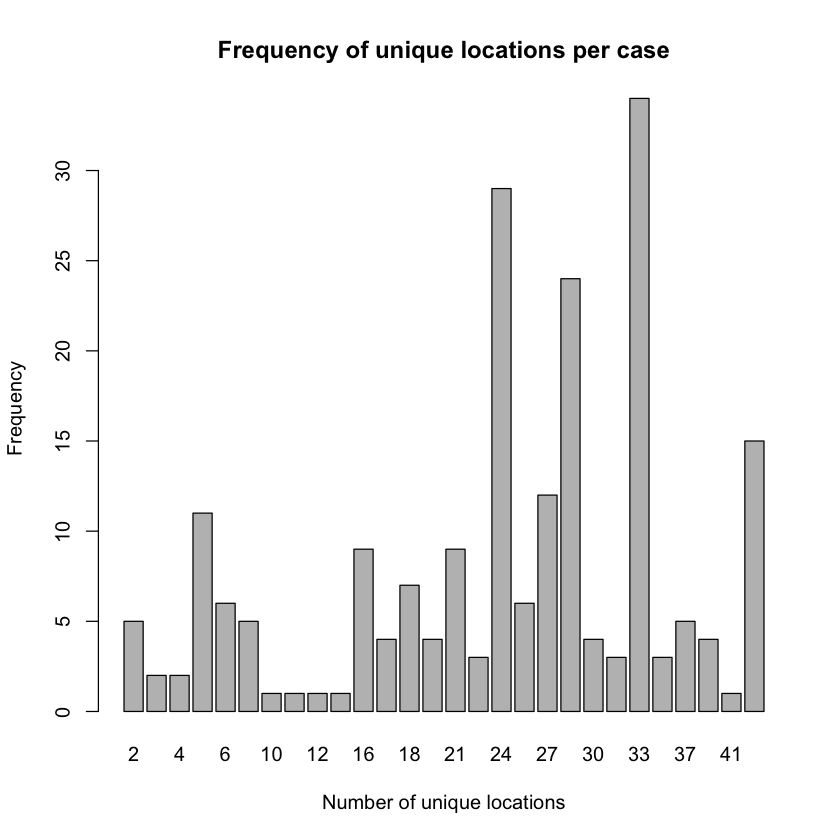

In [29]:
#barplot of count_of_unique_locations for each case

count_of_locations_freq <- count_of_locations_freq %>% 
                                    arrange(count_of_unique_locations)

#set background color to white
par(bg="white")

barplot(count_of_locations_freq$freq, names.arg = count_of_locations_freq$count_of_unique_locations,
 xlab = "Number of unique locations",
 ylab = "Frequency",
  main = "Frequency of unique locations per case")



### Refugees by nationality

In [30]:
### Which nationality has the most refugees
# head(data)

head(data %>% group_by(Nationality_norm) %>% 
        summarise(count = n()) %>%
         arrange(desc(count)),5)

Nationality_norm,count
<fct>,<int>
afghanistan,569
demrepcongo,395
burma,281
syria,162
iraq,49


#### Locations with the most eligible cases

In [31]:
# for each location_id, find the number of eligible cases

cases_per_location <- eligible_cases %>% 
                        group_by(arrival_location_id) %>%
                        summarise(count_of_cases = n()) %>%
                        arrange(desc(count_of_cases))


head(cases_per_location, 5)

tail(cases_per_location, 5)

arrival_location_id,count_of_cases
<chr>,<int>
2cc2591c,188
0a91d577,185
0b8769f2,181
eb58ce03,181
450d082e,178


arrival_location_id,count_of_cases
<chr>,<int>
b5b999a4,25
dc76c896,25
f8083df7,19
a61b01d3,11
635e8445,1


# QUESTION 3 - Algorithmic Placements


APPROACH

For each case (group the cohort data by case to get this information) : do the following: 
 1. For each non free case, assign it to the pre existing location 
 2. For free cases, check eligible locations (calculated in Q2)
 3. Check those locations whose capacity >= case_size
 4. Check for the location with lowest buildup
 5. in case of a tie, choose the one with lowest arrival order
 6. Update buildup and capacity


In [32]:
#copy location capacity dataframe
head(location_capacity, 5)
location_capacity_saved = location_capacity


arrival_location_id,capacity_quota,capacity_rate
<chr>,<dbl>,<dbl>
0a63bef4,57,59.50877
0a91d577,34,99.76471
0b8769f2,32,106.00000
11b8b71f,65,52.18462
18d79a06,47,72.17021


In [33]:
#eligible locations for each case

eligible_locations <- eligible_cases %>% 
                      group_by(case_id) %>%
                      summarise(eligible_locations = list(unique(arrival_location_id)))
                      
head(eligible_locations, 5)
dim(eligible_locations)

case_id,eligible_locations
<chr>,<list>
00ebf80e98ad62ff7fbc2e7b423f592a,"0a91d577, 0b8769f2, 18d79a06, 2cc2591c, 2d268e1a, 2e1d4b95, 3e767dee, 3f92aae8, 450d082e, 45ff63ad, 47d21aa7, 7335b23e, 7a5a9f27, 815e313d, 88311c24, 91350746, b794e0ae, c572d3f4, df4d0d19, eabc1905, eb58ce03, ebaaa580, f8fa5674, f9eceaf1"
01c06c951c9a5f4c57e19975e70f9f6e,"0a91d577, 0b8769f2, 18d79a06, 19334d00, 2449a303, 2c30329f, 2cc2591c, 2d268e1a, 2e1d4b95, 3e767dee, 3f92aae8, 450d082e, 45ff63ad, 47d21aa7, 7335b23e, 7a5a9f27, 815e313d, 88311c24, 91350746, b794e0ae, c572d3f4, cc1dfeed, cdf929eb, df4d0d19, eabc1905, eb58ce03, ebaaa580, f8fa5674, f9eceaf1"
01ec723682e2a490d930a06e38ba6891,"0a63bef4, 0a91d577, 0b8769f2, 11b8b71f, 18d79a06, 19334d00, 19c12683, 2449a303, 2c30329f, 2cc2591c, 2e1d4b95, 3e767dee, 3f60c16b, 3f92aae8, 450d082e, 45ff63ad, 7a5a9f27, 8265f4b2, 91350746, a4c4135a, b794e0ae, c572d3f4, cc1dfeed, cd0b4268, cdf929eb, dea9da1f, df4d0d19, e3d3341c, eabc1905, eb58ce03, ebaaa580, f083c7e8, f8fa5674"
0376d9bd13537af8cd39a4b7143e7ee9,"0a63bef4, 0a91d577, 0b8769f2, 11b8b71f, 18d79a06, 19334d00, 19c12683, 2449a303, 2c30329f, 2cc2591c, 2e1d4b95, 3e767dee, 3f60c16b, 3f92aae8, 450d082e, 45ff63ad, 7a5a9f27, 8265f4b2, 91350746, a4c4135a, b794e0ae, c572d3f4, cc1dfeed, cd0b4268, cdf929eb, dea9da1f, df4d0d19, e3d3341c, eabc1905, eb58ce03, ebaaa580, f083c7e8, f8fa5674"
0421935425294ee30e13f865c168b8f2,"0a63bef4, 0a91d577, 0b8769f2, 11b8b71f, 18d79a06, 2449a303, 2cc2591c, 2e1d4b95, 450d082e, 45ff63ad, 547082d0, 700e77b1, 7a5a9f27, 88311c24, a61b01d3, b794e0ae, c572d3f4, cc1dfeed, cd0b4268, dea9da1f, df4d0d19"


[1] 211   2

In [34]:
#sort data by case_placement_order
data <- data %>% arrange(case_placement_order)

#select unique case ids
case_data =data[!duplicated(data$case_id),] %>% 
    select(case_id, arrival_location_id, case_size, case_placement_order,arrival_location_order,free_case) %>% 
    arrange(case_placement_order)
    
case_data$eligible_locations = eligible_locations[match(case_data$case_id, eligible_locations$case_id),]$eligible_locations

# head(case_data, 5)
dim(case_data)
dim(data)
sum(case_data$case_size)

[1] 1029    7

[1] 1740   14

[1] 3392

In [35]:
location_capacity = location_capacity_saved
location_capacity$available_capacity = location_capacity$capacity_quota

tdf = case_data %>% 
    select(arrival_location_id, arrival_location_order)

location_capacity = location_capacity %>%
                     merge(tdf, by = 'arrival_location_id') 

#remove duplicates of arrival_location_id
location_capacity = location_capacity[!duplicated(location_capacity$arrival_location_id),]
location_capacity$buildup = 0
head(location_capacity, 5)
dim(location_capacity)

,arrival_location_id,capacity_quota,capacity_rate,available_capacity,arrival_location_order,buildup
,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,0a63bef4,57,59.50877,57,24,0
20,0a91d577,34,99.76471,34,48,0
29,0b8769f2,32,106.00000,32,37,0
37,11b8b71f,65,52.18462,65,31,0
58,18d79a06,47,72.17021,47,16,0


[1] 50  6

In [36]:
location_capacity_checkpoint = location_capacity
dim(location_capacity_checkpoint)


[1] 50  6

### Main Algorithm

In [37]:
# main algorithm

location_capacity = location_capacity_checkpoint

#find the number of rows in case_data

num_rows = nrow(case_data)

head(location_capacity %>% arrange(arrival_location_order),2)
print(num_rows)

,arrival_location_id,capacity_quota,capacity_rate,available_capacity,arrival_location_order,buildup
,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,88311c24,104,32.61538,104,1,0
2,2cc2591c,104,32.61538,104,2,0


[1] 1029


### Dataframes to capture the case placement and buildup accumulations

In [38]:
#create empty dataframe with columns location id, case placement id and case size
placement_accum = data.frame(arrival_location_id = character(),
                             case_placement_order = numeric(), 
                             case_size = numeric(), stringsAsFactors = FALSE)
# placement_accum

buildup_accum = c()

algorithmic_case_location  = data.frame(case_id = character(), 
                                    alogrithmic_location = character(), 
                                    stringsAsFactors = FALSE)


In [39]:
#create 2 empty lists for question D
placement_19334d00 = c()
case_size_19334d00 = c()

suppressWarnings({


running_ttl = 0
for(i in 1:num_rows) {
    #iterating through all the cases sorted by case placement order

    curr_case_id = case_data$case_id[i]
    curr_case_size = case_data$case_size[i]
    free_case = case_data$free_case[i]
    running_ttl = running_ttl + curr_case_size

    #question e - buildup accumulation -buildup for all 50 locations in each iteration
    buildup_accum = c(buildup_accum, location_capacity$buildup)

    
    if (free_case == 0) {
        location_id = case_data$arrival_location_id[i] 
    }
   
    if (free_case != 0 ) {

        #choose a location that is eligile for the case and has the capacity to accomodate the case
        eligible_locations_for_case = case_data$eligible_locations[i]

        eligible_locations_with_case_capacity = location_capacity %>% 
         filter(arrival_location_id %in% unlist(eligible_locations_for_case)) %>% 
         filter(available_capacity >= curr_case_size) 


        #choose locations with lowest buildup and lowest arrival_location_order
        eligible_locations_for_case_with_lowest_buildup = eligible_locations_with_case_capacity %>%
            filter(!is.na(buildup),buildup == min(buildup, na.rm=TRUE)) %>%
            filter(!is.na(arrival_location_order),arrival_location_order == min(arrival_location_order, na.rm=TRUE)) %>%
            select(arrival_location_id)

        #if there are no eligible locations, choose the one with the lowest buildup
        if (nrow(eligible_locations_for_case_with_lowest_buildup) == 0) {
            # print(curr_case_id)
            eligible_locations_for_case_with_lowest_buildup = location_capacity %>%
                filter(!is.na(buildup),buildup == min(buildup, na.rm=TRUE)) %>%
                select(arrival_location_id)
        }

        location_id = eligible_locations_for_case_with_lowest_buildup$arrival_location_id[1]
    }

    if (location_id == "19334d00"){
        placement_19334d00 = c(placement_19334d00, case_data$case_placement_order[i])
        case_size_19334d00 = c(case_size_19334d00, curr_case_size)
    }


    #update placement_accum
    placement_accum = rbind(placement_accum, data.frame(arrival_location_id = location_id, case_placement_order = case_data$case_placement_order[i], case_size = curr_case_size))
  

    #update algorithmic_case_location
    algorithmic_case_location = rbind(algorithmic_case_location, data.frame(case_id = curr_case_id, alogrithmic_location = location_id))
    
    #we have location_id for the case

    #update capacity given location_id
    updated_lc = location_capacity %>%
        filter(arrival_location_id == location_id) %>%
        mutate(available_capacity = available_capacity - curr_case_size)


    #update buildup given location_id
    updated_lc = updated_lc %>%
        filter(arrival_location_id == location_id) %>%
        mutate(buildup = max(0, (buildup - curr_case_size)) + (curr_case_size * capacity_rate))

    update_non_lc =  location_capacity %>% 
        filter(arrival_location_id != location_id) %>%
        mutate(buildup = buildup - curr_case_size)

    rbind(updated_lc, update_non_lc) -> location_capacity

}

})


cp1933_df = data.frame(placement = placement_19334d00,  case_size =case_size_19334d00)


In [40]:
# for question d -making it generic
dim(placement_accum)

dim(algorithmic_case_location)
head(algorithmic_case_location, 5)

[1] 1029    3

[1] 1029    2

,case_id,alogrithmic_location
,<chr>,<chr>
1,1d31071c3708db8e408bc7db26f95b2c,88311c24
2,3c01df8e5923ad49c08fe61e41972e32,eb58ce03
3,471c3ac6818d8852b0bbfb82783a90d1,56af9059
4,4ebd2d38396e5de256877b762172507e,b5b999a4
5,510afb02c459e1d430eb3707bed23930,19c12683


### Location 19334d00

,arrival_location_id,case_placement_order,case_size,cumulative_sum
,<chr>,<int>,<dbl>,<dbl>
1,19334d00,39,4,4
2,19334d00,110,1,5
3,19334d00,120,7,12
4,19334d00,148,4,16
5,19334d00,281,1,17


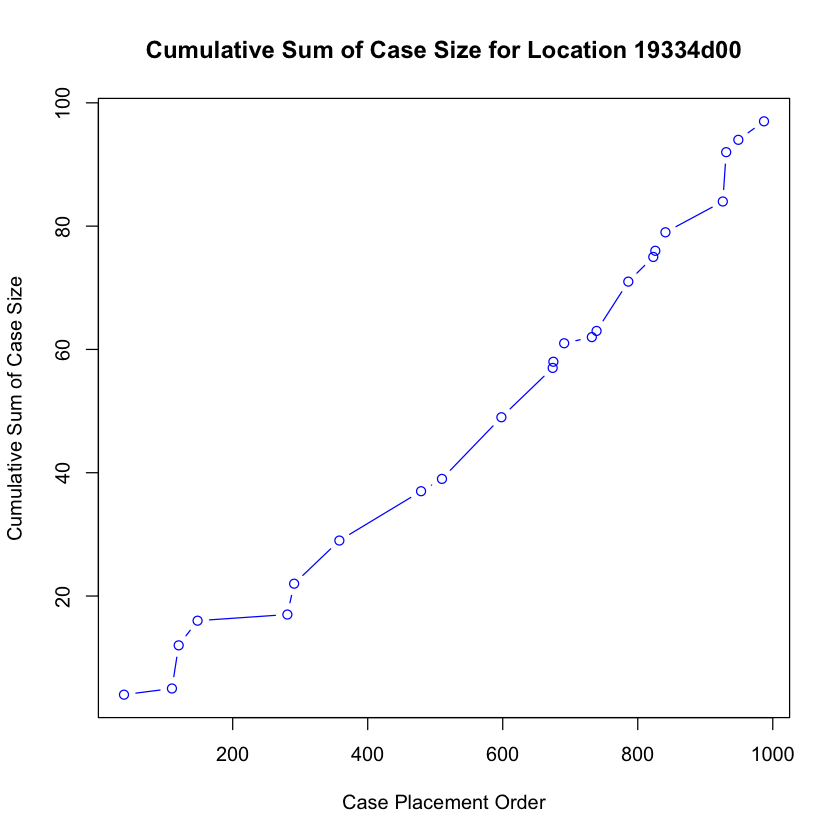

In [41]:
loc_1933 = placement_accum %>% filter(arrival_location_id == "19334d00") %>%
                     arrange(case_placement_order) %>% mutate(cumulative_sum = cumsum(case_size))
head(loc_1933, 5)

par(bg = "white")

#plot of cumulative sum of case size for location 19334d00
plot(loc_1933$case_placement_order, 
loc_1933$cumulative_sum, 
type = "b", col = "blue", 
xlab = "Case Placement Order",
ylab = "Cumulative Sum of Case Size",
main = "Cumulative Sum of Case Size for Location 19334d00")

### Final algorithmic placement outcome

In [42]:
lc2 = location_capacity
# lc2$added_population = lc2$capacity_quota - lc2$available_capacity
lc2$new_population = lc2$capacity_quota - lc2$available_capacity
sum(lc2$new_population)
sum(lc2$capacity_quota)
head(lc2 %>% arrange(available_capacity),50)


[1] 3392

[1] 3392

,arrival_location_id,capacity_quota,capacity_rate,available_capacity,arrival_location_order,buildup,new_population
,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,3f92aae8,47,72.17021,-21,8,1756.31915,68
2,0a91d577,34,99.76471,-14,48,1431.70588,48
3,2449a303,103,32.93204,-13,15,852.07767,116
4,eabc1905,253,13.40711,-12,22,302.88538,265
5,cc1dfeed,56,60.57143,-11,39,1274.71429,67
6,f9eceaf1,121,28.03306,-10,26,507.57851,131
7,815e313d,49,69.22449,-10,44,1475.34694,59
8,c572d3f4,178,19.05618,-9,6,362.13483,187
9,700e77b1,27,125.62963,-9,41,2255.11111,36


### Question 3 Part A

    From the above table , we can see that location 3f92aae8 gained the most population compared to its staus quo. This location gained 21 extra people.


### Question 3 Part B

    From the above table, we see that location f083c7e8 lost the most people - it received 27 fewer people

### Question 3 Part C

    Some locations went over their quotas. One possible reason for this happening is the number of non free cases. When a case isn't free, we don't consider any of the constraints, and therefore this could lead to going over the quota. It is also likely that there are some locations that are popular for refugees and will hence tie incoming refugees to that location. 
    Another reason is the case size

### Question 3 Part D

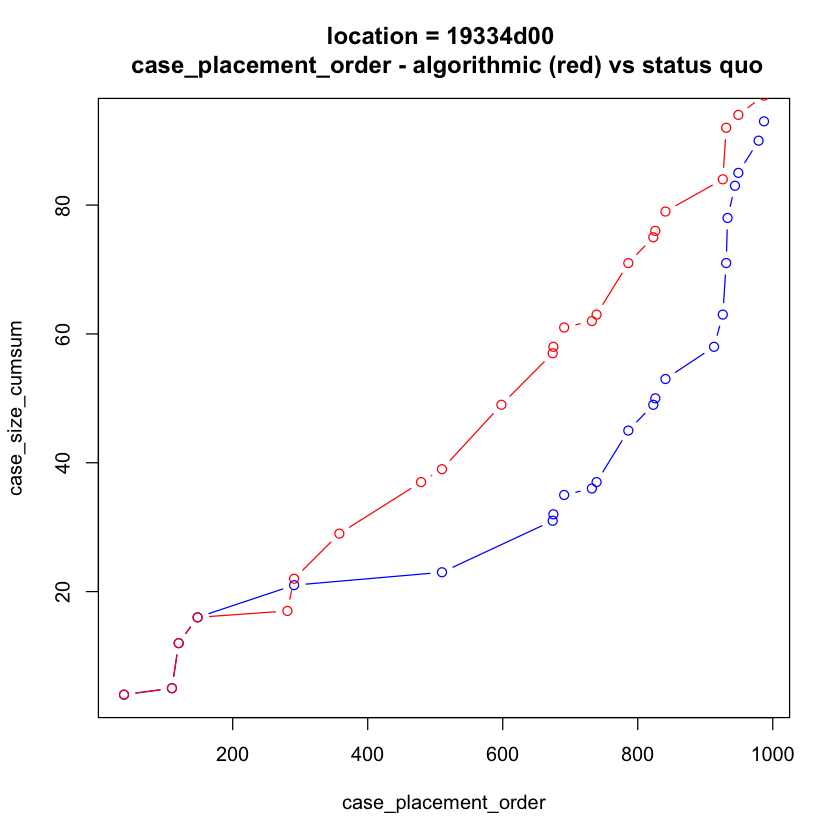

In [43]:
case_data_19334d00 = case_data %>% filter (arrival_location_id == "19334d00")

algo_data_19334d00 = data.frame(placement = placement_19334d00,  case_size =case_size_19334d00)%>% 
                    mutate (case_size_cumsum = cumsum(case_size)) %>% 
                    arrange(placement)

par(bg = "white")

case_data_19334d00$case_size_cumsum = cumsum(case_data_19334d00$case_size)

plot(case_data_19334d00$case_placement_order,
    case_data_19334d00$case_size_cumsum, 
    main = "location = 19334d00 \n case_placement_order - algorithmic (red) vs status quo", 
    xlab = "case_placement_order", 
    ylab = "case_size_cumsum", 
    type = 'b', col = "blue"
    )

par(bg = "white")

lines(algo_data_19334d00$placement, 
    algo_data_19334d00$case_size_cumsum, 
    type = 'b', col = "red"
    )


In [77]:
dim(case_data %>% filter(arrival_location_id == "19334d00"))

case_data %>% filter(arrival_location_id == "19334d00") %>% summarise(sum(free_case))

[1] 23  7

sum(free_case)
<dbl>
4


We can see here that the algorithm smooths out the arrivals compared to status quo. 

,arrival_location_id,case_placement_order,case_size,cumulative_sum
,<chr>,<int>,<dbl>,<dbl>
1,2cc2591c,16,6,6
2,2cc2591c,124,1,7
3,2cc2591c,182,6,13
4,2cc2591c,260,8,21
5,2cc2591c,274,7,28


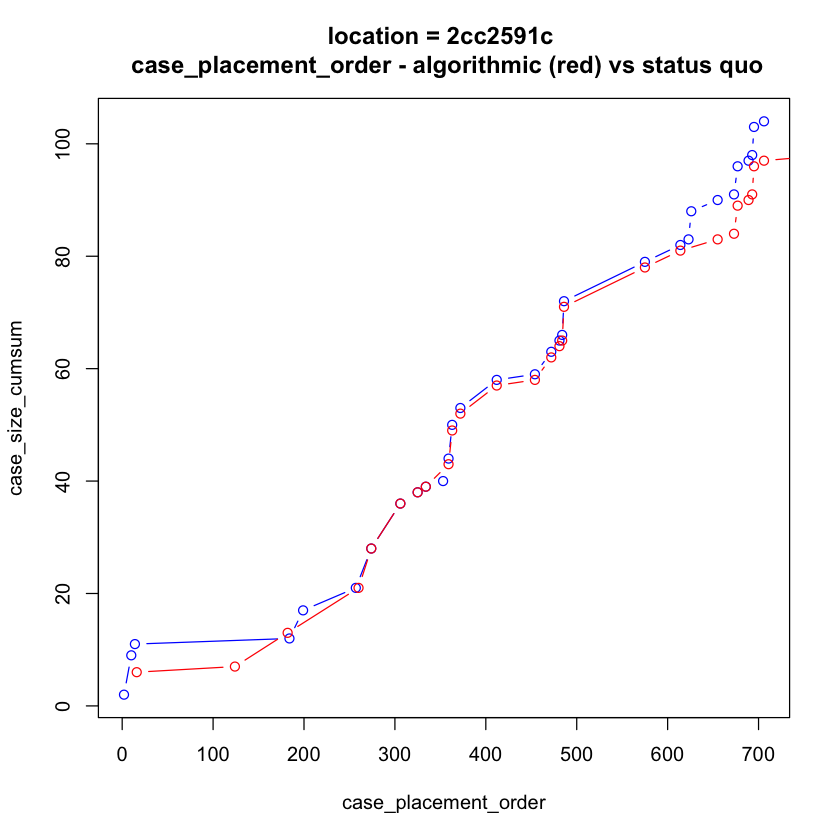

In [44]:
loc_2cc = placement_accum %>% filter(arrival_location_id == "2cc2591c") %>%
                     arrange(case_placement_order) %>% mutate(cumulative_sum = cumsum(case_size))
head(loc_2cc, 5)

par(bg = "white")



case_data_2cc = case_data %>% filter (arrival_location_id == "2cc2591c")


par(bg = "white")

case_data_2cc$case_size_cumsum = cumsum(case_data_2cc$case_size)

plot(case_data_2cc$case_placement_order,
    case_data_2cc$case_size_cumsum, 
    main = "location = 2cc2591c \n case_placement_order - algorithmic (red) vs status quo", 
    xlab = "case_placement_order", 
    ylab = "case_size_cumsum", 
    type = 'b', col = "blue"
    )


lines(loc_2cc$case_placement_order, 
    loc_2cc$cumulative_sum, 
    type = 'b', col = "red"
    )

In [76]:
# most cases are not free for this location

dim(case_data %>% filter(arrival_location_id == "2cc2591c"))

case_data %>% filter(arrival_location_id == "2cc2591c") %>% summarise(sum(free_case))

[1] 31  7

sum(free_case)
<dbl>
9


In [45]:
casetype %>% filter (arrival_location_id == "19334d00" | arrival_location_id == "2cc2591c") 


arrival_location_id,CaseType,Accepted
<chr>,<chr>,<chr>
2cc2591c,SingleIndividualFemale,Yes
2cc2591c,SingleIndividualMale,Yes
2cc2591c,SingleParentFamilies,Yes
19334d00,SingleIndividualFemale,Yes
19334d00,SingleIndividualMale,Yes
19334d00,SingleParentFamilies,No


In [46]:
nationality %>% filter (arrival_location_id == "19334d00" | arrival_location_id == "2cc2591c") 


arrival_location_id,Nationality_norm
<chr>,<chr>
2cc2591c,afghanistan
2cc2591c,burma
2cc2591c,bhutan
2cc2591c,burundi
2cc2591c,demrepcongo
2cc2591c,cameroon
2cc2591c,colombia
2cc2591c,cuba
2cc2591c,djibouti


### Question 3 Part E

In [47]:
mean(buildup_accum)

[1] 418.4242

Avegrage buildup under algorithmic placement is 418.42

### Distribution of Buildup Accumulation

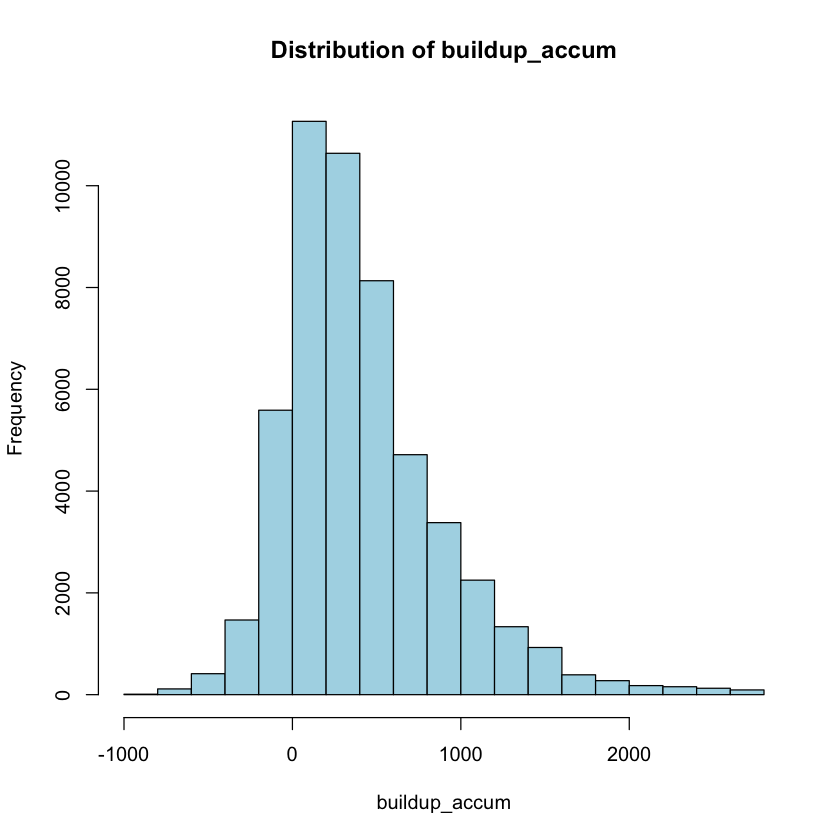

In [48]:
#plot the distribution of buildup_accum

par(bg = "white")

hist(buildup_accum, 
    main = "Distribution of buildup_accum", 
    xlab = "buildup_accum", 
    col = "lightblue", 
    border = "black"
    )

 The average buildup across all locations finally is 418.4

### Question 3 Part F

I would expect the algorithmic average build up to be more evenly distributed than the status quo average build up. This is because while assigning cases to locations, we check across all locations buildup to make sure that no place has too many people.

### Question 3 Part G

Depends on how the status quo placements are made - if they consider constraints, then algorithmic placements will be different when there are no constraint (due to round robin nature). If they do not consider constraints, then algorithm will differ where there are many constraints.

Either way - number of free cases 


I think that case constraints would increase the difference between the algorithmic and status quo average buildups. Cases are assigned locations based on case constraints , and less constraints means that algorithm can assign the cases in a more round robin fashion. Similarly free cases will lead to a difference in average buildups. The more the free cases, the more the cases can be distributed. 

In [49]:
unique_cases = data[!duplicated(data$case_id),] 


In [50]:
#join case_data with algorithmic_case_location
#trying to see which constraints will result in the maximum difference in algorithmic placement and status quo placement

case_data_and_algorithmic_location = case_data %>% 
    left_join(algorithmic_case_location, by = c('case_id' = 'case_id')) %>%
    select(case_id, arrival_location_id, alogrithmic_location)


# head(case_data_and_algorithmic_location,5)


case_data_and_algorithmic_location = case_data_and_algorithmic_location %>%
    left_join(unique_cases, by = c('case_id' = 'case_id')) %>%
    mutate (algo_same = ifelse(arrival_location_id.x == alogrithmic_location, 1, 0)) %>%
    select(case_id, arrival_location_id.x, alogrithmic_location, algo_same, case_size, free_case, hard_singles_male, hard_singles_female, hard_spf) %>%
    arrange(algo_same)


free_case_data_and_algorithmic_location = case_data_and_algorithmic_location %>% filter(free_case == 1)
 
dim(free_case_data_and_algorithmic_location)
head(free_case_data_and_algorithmic_location,5)


[1] 211   9

,case_id,arrival_location_id.x,alogrithmic_location,algo_same,case_size,free_case,hard_singles_male,hard_singles_female,hard_spf
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3c01df8e5923ad49c08fe61e41972e32,2cc2591c,eb58ce03,0,2,1,1,0,1
2,87253f40d2bb0828aebd58d5dacdc64e,2cc2591c,0a91d577,0,7,1,0,0,1
3,fecc7defc2cfeb19c5a59be1f362640c,2cc2591c,3f60c16b,0,2,1,1,0,1
4,101f0746ae4dfe8c6d7607020fd1b50e,eb58ce03,2cc2591c,0,6,1,0,0,0
5,942eeaacb5c9678d9381d8f93a524a47,c572d3f4,b794e0ae,0,1,1,0,0,0


In [51]:
# count of cases by free case and algo_same
# case_data_and_algorithmic_location %>% group_by(free_case, algo_same) %>% summarise(count = n())

# free_case_data_and_algorithmic_location %>% group_by( algo_same,hard_singles_female) %>% summarise(count = n())

# free_case_data_and_algorithmic_location %>% group_by( algo_same,hard_singles_male) %>% summarise(count = n())

# free_case_data_and_algorithmic_location %>% group_by( algo_same,hard_spf) %>% summarise(count = n())

### Question 3 Part H

I think one factor that we can look at is rate of intake of cases. It is slightly from buildup in the sense that we look at the pattern of the locations previous intakes. We can maintain a priority queue, and locations with a lower rate of intake can be assigned a higher priority - new cases can be assigned to them. This way we can further ensure that cases are distributed and no place is overloaded.


### Question 3 Part I- Avg Buildup under status quo

In [52]:
# head(location_capacity_checkpoint,2)
location_capacity_copy = location_capacity_checkpoint
# head(location_capacity_copy,2)

#ordering by arrival_location_order
location_capacity_copy = location_capacity_copy %>%
                         arrange(arrival_location_order)
head(location_capacity_copy,5)

status_quo_buildup_accum = c()


,arrival_location_id,capacity_quota,capacity_rate,available_capacity,arrival_location_order,buildup
,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,88311c24,104,32.61538,104,1,0
2,2cc2591c,104,32.61538,104,2,0
3,56af9059,141,24.05674,141,3,0
4,b5b999a4,140,24.22857,140,4,0
5,19c12683,172,19.72093,172,5,0


In [53]:
#calculating buildup 

case_data_copy =data[!duplicated(data$case_id),] %>% 
    select(case_id, arrival_location_id, case_size, case_placement_order,arrival_location_order,free_case) %>% 
    arrange(case_placement_order)

In [54]:
num_rows = nrow(case_data_copy)

for (i in 1:num_rows) {


    curr_arrival_location_id = case_data_copy$arrival_location_id[i]
    curr_case_size = case_data_copy$case_size[i]

    # print(curr_arrival_location_id)
    # print(curr_case_size)
    # print('*********')

    status_quo_buildup_accum = c(status_quo_buildup_accum, location_capacity_copy$buildup)

    #update capacity given location_id
    updated_lc = location_capacity_copy %>%
        filter(arrival_location_id == curr_arrival_location_id) %>%
        mutate(available_capacity = available_capacity - curr_case_size)

    # update buildup given location_id
    updated_lc= updated_lc %>%
        filter(arrival_location_id == curr_arrival_location_id) %>%
        mutate(buildup = max(0, (buildup - curr_case_size)) + (curr_case_size * capacity_rate))


    #update buildup of non location_id
    update_non_lc =  location_capacity_copy %>% 
        filter(arrival_location_id != curr_arrival_location_id) %>%
        mutate(buildup = buildup - curr_case_size)



    location_capacity_copy =  rbind(updated_lc, update_non_lc) 



}


In [55]:
#find the average buildup
avg_buildup = mean(status_quo_buildup_accum)
avg_buildup

[1] 464.3522

Average buildup under status quo placments is 464.35 (agorithmic - 418.42)

### Distributions of buildups for status quo and algorithmic placements

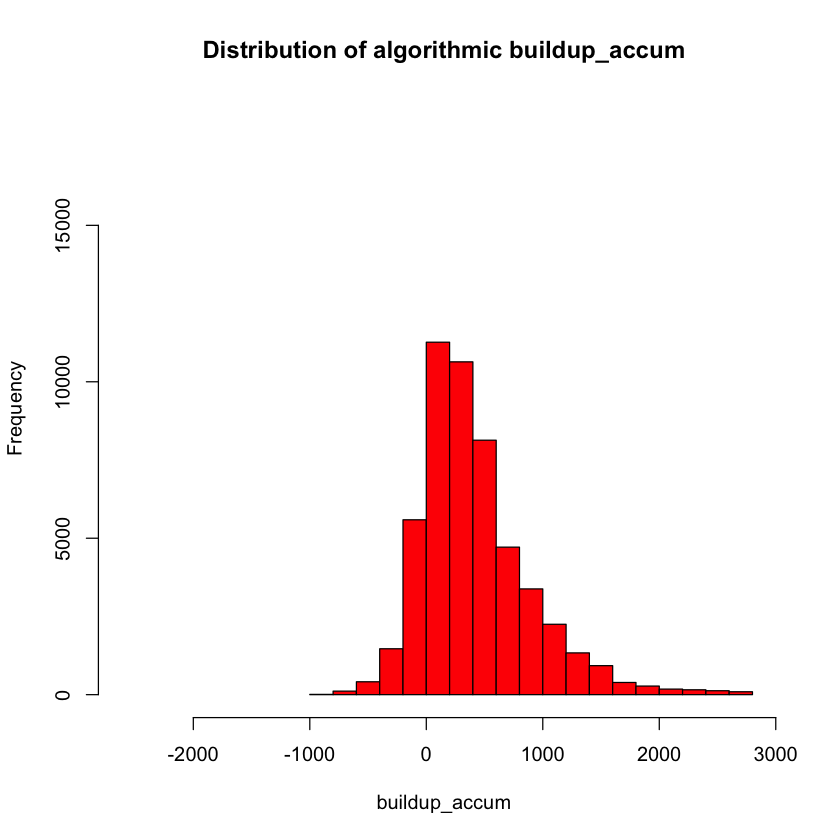

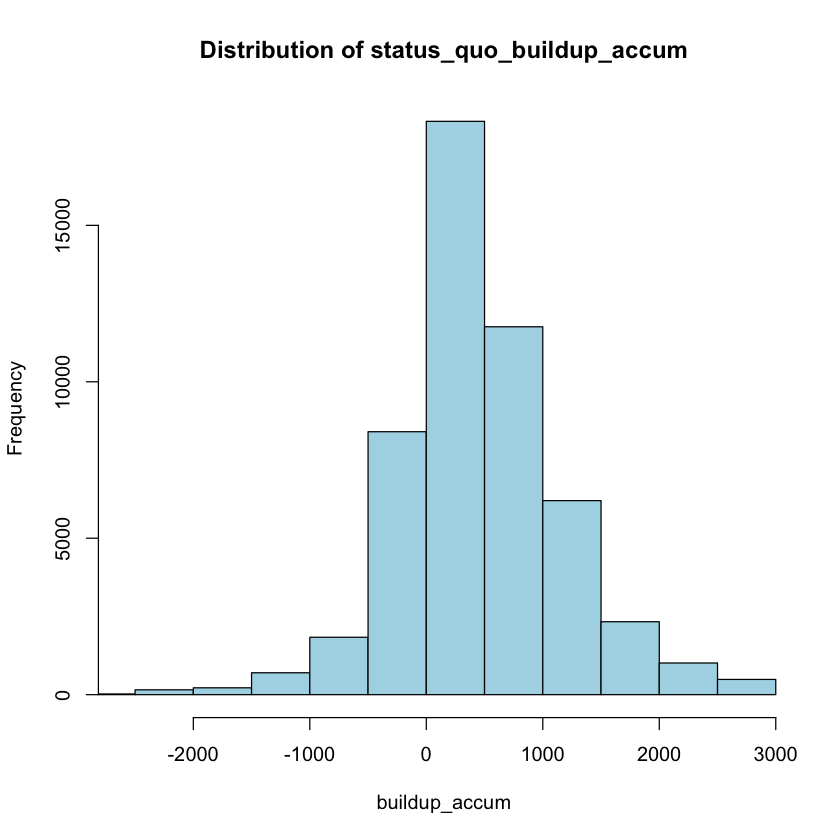

In [56]:
#plot the distribution of buildup_accum

common_range <- range(c(buildup_accum, status_quo_buildup_accum))

#calculate histogram without plotting
hist_buildup <- hist(buildup_accum, plot = FALSE)
hist_status_quo_buildup <- hist(status_quo_buildup_accum, plot = FALSE)

# Find the maximum frequency from both histograms
max_freq <- max(hist_buildup$counts, hist_status_quo_buildup$counts)


par(bg = "white")
hist(buildup_accum, 
    main = "Distribution of algorithmic buildup_accum", 
    xlab = "buildup_accum", 
    col = "red", 
    border = "black",
    xlim = common_range,
    ylim = c(0, max_freq)
    )

par(bg = "white")
hist(status_quo_buildup_accum, 
    main = "Distribution of status_quo_buildup_accum", 
    xlab = "buildup_accum", 
    col = "lightblue", 
    border = "black",
    xlim = common_range,
    ylim = c(0, max_freq)
    )



### plots of buildups for everything but the first 4 cycles

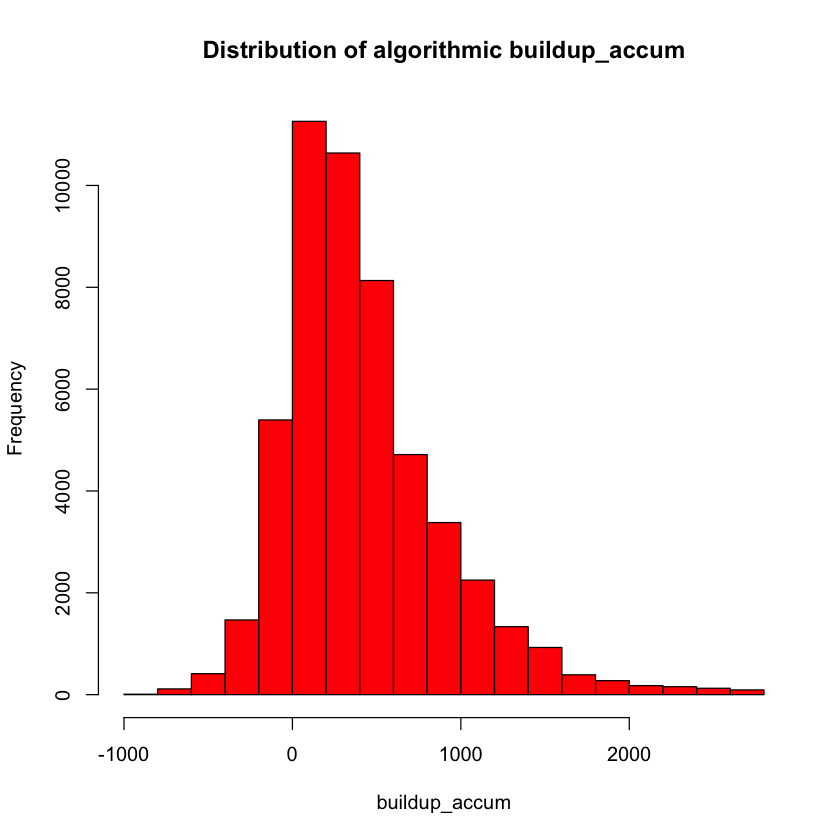

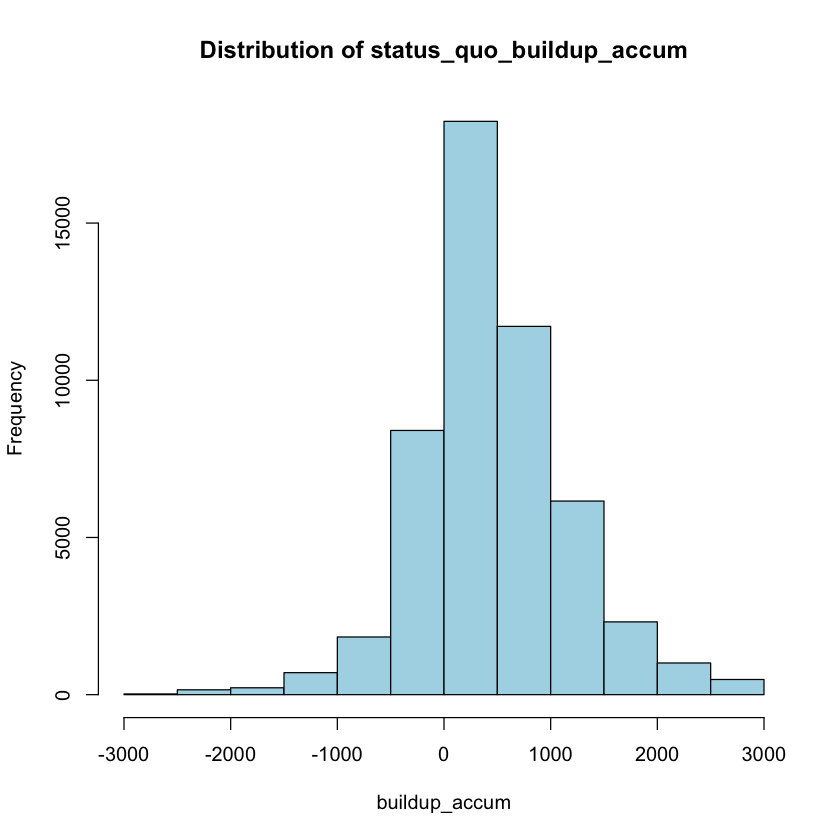

In [57]:
#plot the distribution of buildup_accum

#everything but the first four cycles

par(bg = "white")
hist(tail(buildup_accum, 
        length(buildup_accum)-200) , 
        main = "Distribution of algorithmic buildup_accum",
        xlab = "buildup_accum", 
        col = "red", 
        border = "black")


par(bg = "white")
hist(head(status_quo_buildup_accum, 
    length(status_quo_buildup_accum)-200),
     main = "Distribution of status_quo_buildup_accum", 
     xlab = "buildup_accum", 
     col = "lightblue",
      border = "black")

#algorithmic better because more locations with less buildup and less locations with more buildup

In [58]:
#plot the distribution of buildup_accum

# par(bg = "white")
#     hist(tail(buildup_accum,100),
#     main = "Distribution of algorithmic buildup_accum", 
#     xlab = "buildup_accum", 
#     col = "red", 
#     border = "black")

# par(bg = "white")
#     hist(tail(status_quo_buildup_accum,100),
#     main = "Distribution of status_quo_buildup_accum",
#     xlab = "buildup_accum", 
#     col = "lightblue", 
#     order = "black")

# Problem 2

For this question, we want to check how many jobs per month each immigrant has

### Approach
 1. In the Dem data, create a column of all the 36 months we are interested in. (in date -> 3 years after)
 2. In the job data, for each row , create a list of all the months where the person was employed.
 3. Group the job data by person_id -> we will get a df of person_id and all the months they were employed
 4. Join the dem data with the grouped job data and find the intersection of the months (i.e intersection of months employed and the first 36 months)
 5. This resulting DF will give us the employment information for that period of 36 months.

In [59]:
demdf = read.csv('data/dem_dat.csv')
head(demdf, 5)
jobdf = read.csv('data/job_dat.csv')
head(jobdf,5)

,PERS_ID,YM_in,YM_out
,<int>,<int>,<int>
1,117620359,201108,201412
2,118209775,201201,201804
3,118897301,201009,201412
4,119235707,201305,201712
5,120243185,200803,201711


,PERS_ID,YM_start,YM_end
,<int>,<int>,<int>
1,114366763,201711,201802
2,116609197,199408,199408
3,116609197,199408,199508
4,116609197,200103,200301
5,117477969,199406,199505


In [60]:
# check if there are multiple rows for a single PERS_ID in demdf

demdf %>%
    group_by(PERS_ID) %>% 
    summarise(count = n()) %>% 
    filter(count > 1)

PERS_ID,count
<int>,<int>


In [61]:
#convert integer to date
demdf$YM_in_date <- as.Date(paste0(as.character(demdf$YM_in), '01'), format='%Y%m%d')
demdf$YM_out_date <- as.Date(paste0(as.character(demdf$YM_out), '01'), format='%Y%m%d')
#diff in months between YM_in and YM_out date
demdf$YM_diff <- as.numeric(difftime(demdf$YM_out_date, demdf$YM_in_date, units = 'weeks'))/4
head(demdf, 5)


#do the same thing for jobdf
jobdf$job_start_date <- as.Date(paste0(as.character(jobdf$YM_start), '01'), format='%Y%m%d')
jobdf$job_end_date <- as.Date(paste0(as.character(jobdf$YM_end), '01'), format='%Y%m%d')

,PERS_ID,YM_in,YM_out,YM_in_date,YM_out_date,YM_diff
,<int>,<int>,<int>,<date>,<date>,<dbl>
1,117620359,201108,201412,2011-08-01,2014-12-01,43.50000
2,118209775,201201,201804,2012-01-01,2018-04-01,81.50000
3,118897301,201009,201412,2010-09-01,2014-12-01,55.42857
4,119235707,201305,201712,2013-05-01,2017-12-01,59.82143
5,120243185,200803,201711,2008-03-01,2017-11-01,126.14286


In [62]:
head(jobdf)

,PERS_ID,YM_start,YM_end,job_start_date,job_end_date
,<int>,<int>,<int>,<date>,<date>
1,114366763,201711,201802,2017-11-01,2018-02-01
2,116609197,199408,199408,1994-08-01,1994-08-01
3,116609197,199408,199508,1994-08-01,1995-08-01
4,116609197,200103,200301,2001-03-01,2003-01-01
5,117477969,199406,199505,1994-06-01,1995-05-01
6,117477969,199505,199608,1995-05-01,1996-08-01


In [63]:
#df of person and months they were employed for
library("dplyr")
jobdf$months <- mapply(function(start, end) {
# c(seq(start, end, by = "month"))
  format(seq(start, end, by = "month"), "%Y%m")
}, jobdf$job_start_date, jobdf$job_end_date)

#sort by person_id
jobdf <- jobdf %>% arrange(PERS_ID)


#group by person_id and concatenate the months
person_employed_months <- jobdf %>% 
                            group_by(PERS_ID) %>%
                            summarise(months = unique(list(unlist(months))))
                            

dim(person_employed_months)


[1] 23102     2

In [64]:
person_employed_months$num_months <- lengths(person_employed_months$months)
head(person_employed_months)

PERS_ID,months,num_months
<int>,<list>,<int>
114366763,"201711, 201712, 201801, 201802",4
116609197,"199408, 199408, 199409, 199410, 199411, 199412, 199501, 199502, 199503, 199504, 199505, 199506, 199507, 199508, 200103, 200104, 200105, 200106, 200107, 200108, 200109, 200110, 200111, 200112, 200201, 200202, 200203, 200204, 200205, 200206, 200207, 200208, 200209, 200210, 200211, 200212, 200301",37
117477969,"199406, 199407, 199408, 199409, 199410, 199411, 199412, 199501, 199502, 199503, 199504, 199505, 199505, 199506, 199507, 199508, 199509, 199510, 199511, 199512, 199601, 199602, 199603, 199604, 199605, 199606, 199607, 199608, 201508, 201510, 201511, 201512, 201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608, 201609, 201610, 201611, 201612",44
117735987,"200007, 200105, 200106, 200107, 200108, 200109, 200110, 200111, 200207, 200208, 200209, 200210, 200211, 200305",14
118209775,"201512, 201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608, 201609, 201610, 201611, 201612, 201701, 201702, 201703, 201704, 201705, 201706, 201707, 201708, 201709, 201710, 201711, 201712, 201801, 201802, 201803, 201804",29
118298911,"200109, 200110, 200111, 200112, 200201, 200202, 200203, 200204, 200205, 200206",10


In [65]:
# the first 36 months of each person

#create a column for 3 years after YM_in_date
demdf$year3 =  demdf$YM_in_date + 3*365

demdf$months_36 = mapply(function(start, end) {
  format(seq(start, end, by = "month"), "%Y%m")
}, demdf$YM_in_date, demdf$year3)



demdf$months_36_len = lengths(demdf$months_36)
head(demdf,4)

,PERS_ID,YM_in,YM_out,YM_in_date,YM_out_date,YM_diff,year3,months_36,months_36_len
,<int>,<int>,<int>,<date>,<date>,<dbl>,<date>,<list>,<int>
1,117620359,201108,201412,2011-08-01,2014-12-01,43.50000,2014-07-31,"201108, 201109, 201110, 201111, 201112, 201201, 201202, 201203, 201204, 201205, 201206, 201207, 201208, 201209, 201210, 201211, 201212, 201301, 201302, 201303, 201304, 201305, 201306, 201307, 201308, 201309, 201310, 201311, 201312, 201401, 201402, 201403, 201404, 201405, 201406, 201407",36
2,118209775,201201,201804,2012-01-01,2018-04-01,81.50000,2014-12-31,"201201, 201202, 201203, 201204, 201205, 201206, 201207, 201208, 201209, 201210, 201211, 201212, 201301, 201302, 201303, 201304, 201305, 201306, 201307, 201308, 201309, 201310, 201311, 201312, 201401, 201402, 201403, 201404, 201405, 201406, 201407, 201408, 201409, 201410, 201411, 201412",36
3,118897301,201009,201412,2010-09-01,2014-12-01,55.42857,2013-08-31,"201009, 201010, 201011, 201012, 201101, 201102, 201103, 201104, 201105, 201106, 201107, 201108, 201109, 201110, 201111, 201112, 201201, 201202, 201203, 201204, 201205, 201206, 201207, 201208, 201209, 201210, 201211, 201212, 201301, 201302, 201303, 201304, 201305, 201306, 201307, 201308",36
4,119235707,201305,201712,2013-05-01,2017-12-01,59.82143,2016-04-30,"201305, 201306, 201307, 201308, 201309, 201310, 201311, 201312, 201401, 201402, 201403, 201404, 201405, 201406, 201407, 201408, 201409, 201410, 201411, 201412, 201501, 201502, 201503, 201504, 201505, 201506, 201507, 201508, 201509, 201510, 201511, 201512, 201601, 201602, 201603, 201604",36
5,120243185,200803,201711,2008-03-01,2017-11-01,126.14286,2011-03-01,"200803, 200804, 200805, 200806, 200807, 200808, 200809, 200810, 200811, 200812, 200901, 200902, 200903, 200904, 200905, 200906, 200907, 200908, 200909, 200910, 200911, 200912, 201001, 201002, 201003, 201004, 201005, 201006, 201007, 201008, 201009, 201010, 201011, 201012, 201101, 201102, 201103",37
6,120286227,201108,201711,2011-08-01,2017-11-01,81.57143,2014-07-31,"201108, 201109, 201110, 201111, 201112, 201201, 201202, 201203, 201204, 201205, 201206, 201207, 201208, 201209, 201210, 201211, 201212, 201301, 201302, 201303, 201304, 201305, 201306, 201307, 201308, 201309, 201310, 201311, 201312, 201401, 201402, 201403, 201404, 201405, 201406, 201407",36


In [66]:
#Joining these dfs

demdf_subset <- demdf %>% select(PERS_ID, months_36)

# head(demdf_subset, 2)
# head(person_employed_months, 2)

result <- left_join(demdf_subset, person_employed_months, by = "PERS_ID")

#take the intersection of months_36 and months
result$employed_months <- mapply(function(x, y) {
  intersect(x, y)
}, result$months_36, result$months)

result$employed_months_len = lengths(result$employed_months)

result =result %>% select(PERS_ID, employed_months_len)


head(result, 20)

summary(result$employed_months_len)


,PERS_ID,employed_months_len
,<int>,<int>
1,117620359,0
2,118209775,0
3,118897301,0
4,119235707,0
5,120243185,5
6,120286227,5
7,120640421,2
8,120779575,0
9,120938691,1


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   5.386   8.000  37.000 

### From the table above we can see that 
    mean : 5.386
    median : 0
    max : 36

note: as a limitation , there is an off by 1 error for some cases while calculating the first 36 months. 